In [19]:
from logging import raiseExceptions
from tokenize import Double
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from vec3 import Vec3
import meshplot as mp
import torch
torch.manual_seed(125)
import random
random.seed(125)
import torch_f as torch_f
from modelo import Node, GRASSEncoder, GRASSDecoder


Funciones extra

In [20]:
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

In [21]:
def plotTree( root, dec ):
    graph = nx.Graph()
    root.toGraph( graph, 0, dec)
    edges=nx.get_edge_attributes(graph,'procesada')

    p = mp.plot( np.array([ graph.nodes[v]['posicion'] for v in graph.nodes]), shading={'point_size':0.1}, return_plot=True)

    for arista in graph.edges:
        p.add_lines( graph.nodes[arista[0]]['posicion'], graph.nodes[arista[1]]['posicion'])

    return 

def traverse(root, tree):
       
        if root is not None:
            traverse(root.left, tree)
            tree.append((root.radius, root.data))
            traverse(root.right, tree)
            return tree

def traverse_2(tree1, tree2, t_l):
       
        if tree1 is not None:
            traverse_2(tree1.left, tree2.left, t_l)
            if tree2:
                t_l.append((tree1.radius, tree2.radius))
                print((tree1.radius, tree2.radius))
            else:
                t_l.append(tree1.radius)
                print((tree1.radius))
            traverse_2(tree1.right, tree2, t_l)
            return t_l
            

def traverse_conexiones(root, tree):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            traverse_conexiones(root.left, tree)
            if root.right is not None:
                tree.append((root.data, root.right.data))
            if root.left is not None:
                tree.append((root.data, root.left.data))
            traverse_conexiones(root.right, tree)
            return tree

def arbolAGrafo (nodoRaiz):
    
    conexiones = []
    lineas = traverse_conexiones(nodoRaiz, conexiones)
    tree = []
    tree = traverse(nodoRaiz, tree)

    vertices = []
    verticesCrudos = []
    for node in tree:
        vertice = node[0][0][:3]
        rad = node[0][0][-1]
        num = node[1]
        
        #vertices.append((num, {'posicion': Vec3( vertice[0], vertice[1], vertice[2]), 'radio': rad} ))
        vertices.append((len(verticesCrudos),{'posicion': Vec3( vertice[0], vertice[1], vertice[2]), 'radio': rad}))
        verticesCrudos.append(vertice)


    G = nx.Graph()
    G.add_nodes_from( vertices )
    G.add_edges_from( lineas )
    
    return G


def createNode(data, radius, position = None, left = None, right = None, cl_prob = None, ce = None, mse=None):
        """
        Utility function to create a node.
        """
        return Node(data, radius, position, left, right, cl_prob, ce, mse)
 
def deserialize(data):
    if  not data:
        return 
    nodes = data.split(';')  
    #print("node",nodes[3])
    def post_order(nodes):
                
        if nodes[-1] == '#':
            nodes.pop()
            return None
        node = nodes.pop().split('_')
        data = int(node[0])
        #radius = float(node[1])
        #print("node", node)
        #breakpoint()
        radius = node[1]
        #print("radius", radius)
        rad = radius.split(",")
        rad [0] = rad[0].replace('[','')
        rad [3] = rad[3].replace(']','')
        r = []
        for value in rad:
            r.append(float(value))
        #r =[float(num) for num in radius if num.isdigit()]
        r = torch.tensor(r, device=device)
        #breakpoint()
        root = createNode(data, r)
        root.right = post_order(nodes)
        root.left = post_order(nodes)
        
        return root    
    return post_order(nodes)    


def read_tree(filename):
    #with open('./trees/' +'prof3/' +filename, "r") as f:
    with open('./trees/' +filename, "r") as f:
        byte = f.read() 
        return byte

Encoder

In [22]:
Grassencoder = GRASSEncoder(input_size = 4, feature_size=512, hidden_size=1024)
Grassencoder = Grassencoder.to(device)


def encode_structure_fold(fold, root):
    
    
    def encode_node(node):
        
        if node is None:
            return
        
        if node.is_leaf():
            return fold.add('leafEncoder', node.radius)
        else:
            left = encode_node(node.left)
            right = encode_node(node.right)
            if left is not None:
             
                return fold.add('bifurcationEncoder', node.radius, right, left)
            else:
                return fold.add('internalEncoder', node.radius, right)
        

    encoding = encode_node(root)
    
    return encoding
  
def encode_structure(root):
    
    def encode_node(node):
          
        if node is None:
            return
        if node.is_leaf():
            return Grassencoder.leafEncoder(node.radius.reshape(-1,4))
        else :
            left = encode_node(node.left)
            right = encode_node(node.right)
            if left is not None:
                return Grassencoder.bifurcationEncoder(node.radius.reshape(-1,4), right, left)
            else:
                return Grassencoder.internalEncoder(node.radius.reshape(-1,4), right)
        

    encoding = encode_node(root)
   
    return encoding
  

extra

In [23]:
def numerar_nodos(root, count):
    if root is not None:
        numerar_nodos(root.left, count)
        root.data = len(count)
        count.append(1)
        numerar_nodos(root.right, count)
        return 


def traversefeatures(root, features):
       
    if root is not None:
        traversefeatures(root.left, features)
        features.append(root.radius)
        traversefeatures(root.right, features)
        return features

def norm(root, minx, miny, minz, minr, maxx, maxy, maxz, maxr):
    
    if root is not None:
        mx = minx.clone().detach()
        my = miny.clone().detach()
        mz = minz.clone().detach()
        mr = minr.clone().detach()
        Mx = maxx.clone().detach()
        My = maxy.clone().detach()
        Mz = maxz.clone().detach()
        Mr = maxr.clone().detach()
       
        root.radius[0] = (root.radius[0] - minx)/(maxx - minx)
        root.radius[1] = (root.radius[1] - miny)/(maxy - miny)
        root.radius[2] = (root.radius[2] - minz)/(maxz - minz)
        root.radius[3] = (root.radius[3] - minr)/(maxr - minr)
        
        norm(root.left, mx, my, mz, mr, Mx, My, Mz, Mr)
        norm(root.right, mx, my, mz, mr, Mx, My, Mz, Mr)
        return 

def normalize_features(root):
    features = []
    features = traversefeatures(root, features)
    
    x = [tensor[0] for tensor in features]
    y = [tensor[1] for tensor in features]
    z = [tensor[2] for tensor in features]
    r = [tensor[3] for tensor in features]
 
    norm(root, min(x), min(y), min(z), min(r), max(x), max(y), max(z), max(r))

    return 

def traversefeatures(root, features):
       
    if root is not None:
        traversefeatures(root.left, features)
        features.append(root.radius)
        traversefeatures(root.right, features)
        return features


Data loader

In [24]:
def my_collate(batch):
    return batch

#t_list = ['ArteryObjAN1-7.dat','ArteryObjAN1-0.dat', 'ArteryObjAN1-17.dat',  'ArteryObjAN1-11.dat']

#t_list = ['ArteryObjAN1-0.dat','ArteryObjAN1-7.dat', 'ArteryObjAN1-17.dat',  'ArteryObjAN1-11.dat', 'ArteryObjAN1-19.dat', 'ArteryObjAN2-4.dat', 'ArteryObjAN2-6.dat', 
#           'ArteryObjAN25-18.dat']
#t_list = ['ArteryObjAN1-17-55.dat', 'ArteryObjAN1-17-22.dat', "ArteryObjAN1-17-12.dat", "ArteryObjAN1-17-9.dat",'ArteryObjAN1-17-42.dat', 'ArteryObjAN1-17-64.dat', "ArteryObjAN1-17-70.dat", "ArteryObjAN1-17-1.dat"]
#t_list = ['ArteryObjAN1-17.dat']
#t_list = ['ArteryObjAN1-11.dat']


#t_list = ['test2.dat']

#t_list = ['ArteryObjAN31-14.dat']
#t_list = os.listdir("./trees")[:20]
t_list = os.listdir("./trees/prof5")[:20]
print(t_list)
class tDataset(Dataset):
    def __init__(self, dir, transform=None):
        self.names = dir
        self.transform = transform
        self.data = [] #lista con las strings de todos los arboles
        for file in self.names:
            self.data.append(read_tree('prof5/'+file))
        self.trees = []
        for tree in self.data:
            deserial = deserialize(tree)
            normalize_features(deserial)
            self.trees.append(deserial)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        #file = self.names[idx]
        #string = read_tree(file)
        tree = self.trees[idx]
        return tree

batch_size = 10
dataset = tDataset(t_list)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True, collate_fn=my_collate)


['tree0.dat', 'tree1.dat', 'tree10.dat', 'tree100.dat', 'tree101.dat', 'tree102.dat', 'tree103.dat', 'tree104.dat', 'tree105.dat', 'tree106.dat', 'tree107.dat', 'tree108.dat', 'tree109.dat', 'tree11.dat', 'tree110.dat', 'tree111.dat', 'tree112.dat', 'tree113.dat', 'tree114.dat', 'tree115.dat']


In [25]:
n_no = []
qzero = 0
qOne = 0
qtwo = 0

for batch in data_loader:
    for tree in batch:
        count = []
        n = tree.count_nodes(tree, count)
        n_no.append(len(n))
        li = []
        tree.traverseInorderChilds(tree, li)
        zero = [a for a in li if a == 0]
        one = [a for a in li if a == 1]
        two = [a for a in li if a == 2]
        qzero += len(zero)
        qOne += len(one)
        qtwo += len(two)

print(len(data_loader)*batch_size)
print(n_no)
nprom = np.mean(n_no)
print(nprom)
qzero /= len(data_loader)*batch_size
qOne /= len(data_loader)*batch_size
qtwo /= len(data_loader)*batch_size

print(qzero)
print(qOne)
print(qtwo)

20
[13, 5, 5, 5, 8, 8, 6, 8, 7, 8, 5, 6, 5, 5, 5, 5, 5, 10, 5, 5]
6.45
3.7
2.05
0.7


In [26]:
if round(qzero) == 0:
    qzero = 1
if round(qOne) == 0:
    qOne = 1
if round(qtwo) == 0:
    qtwo = 1
mult = torch.tensor([1/round(qzero),1/round(qOne),1/round(qtwo)], device = device)

Grassdecoder = GRASSDecoder(latent_size=512, hidden_size=1024, mult = mult)
Grassdecoder = Grassdecoder.to(device)

Decode structure

In [27]:
print(qzero)
print(qOne)
print(qtwo)

3.7
2.05
0.7


In [28]:
print(mult)
def calcularLossEstructura(cl_p, original):
    
    if original is None:
        return
    #mult = torch.tensor([1/round(qzero),1/round(qOne),1/round(qtwo)], device = device)
    ce = nn.CrossEntropyLoss(weight = mult)

    if original.childs() == 0:
        vector = [1, 0, 0] 
    if original.childs() == 1:
        vector = [0, 1, 0]
    if original.childs() == 2:
        vector = [0, 0, 1] 


    c = ce(cl_p, torch.tensor(vector, device=device, dtype = torch.float).reshape(1, 3))
    #print("original", vector)
    #print("clasificador", cl_p)
    #print("ce", 0.4*c)
    return c


def calcularLossAtributo(nodo, radio):
    if nodo is None:
        return
    #print("nodo", nodo)
    #print("radio", radio)

    radio = radio.reshape(-1,4)
    nodo = nodo.radius.reshape(-1,4)
    l2    = nn.MSELoss()
   
    mse = l2(radio, nodo)
    #print("mse", mse)
    return mse

tensor([0.2500, 0.5000, 1.0000], device='cuda:0')


In [29]:
def searchNode(node, key):
     
    if (node == None):
        return False
 
    if (node.data == key):
        return node
        
 
    """ then recur on left subtree """
    res1 = searchNode(node.left, key)
    # node found, no need to look further
    if res1:
        return res1
 
    """ node is not found in left,
    so recur on right subtree """
    res2 = searchNode(node.right, key)
    return res2

In [30]:
def getLevelUtil(node, data, level):
    if (node == None):
        return 0
 
    if (node.data == data):
        return level
 
    downlevel = getLevelUtil(node.left, data, level + 1)

    if (downlevel != 0):
        return downlevel
 
    downlevel = getLevelUtil(node.right, data, level + 1)
    return downlevel
 
# Returns level of given data value
 
 
def getLevel(node, data):
    return getLevelUtil(node, data, 1)
 

In [31]:
for d in data_loader:
    for data in d:
        count = []
        numerar_nodos(data, count)
        c = []
        n_nodes = data.count_nodes(data, c)
        for x in range(0, len(n_nodes)):
            level = getLevel(data, x)
            if (level):
                #print("Level of", x, "is", getLevel(input, x))
                node = searchNode(data, x)
                node.level = getLevel(data, x)
            else:
                print(x, "is not present in tree")
        tree_level = []
        data.get_tree_level(data, tree_level)
        data.set_tree_level(data, sum(tree_level))

In [32]:
def decode_structure_fold_grass(fold, v, root):
   
    def decode_node(fold, v, node):
        
        
        if node.childs() == 0 : 

            radio = fold.add('featureDecoder', v)
            lossAtributo = fold.add('calcularLossAtributo', node, radio)

            label = fold.add('nodeClassifier', v)
            
            lossEstructura = fold.add('classifyLossEstimator', label, node)  
            multipl = node.level/node.treelevel
            losse = fold.add('vectorMult', multipl, lossEstructura)
            
            loss =  fold.add('vectorAdder', losse, lossAtributo)       
            return loss

            
            
        elif node.childs() == 1 :
            right, radius = fold.add('internalDecoder', v).split(2)
            label = fold.add('nodeClassifier', v)
            nodoSiguiente = node.right
            if nodoSiguiente is not None:
                right_loss = decode_node(fold, right, nodoSiguiente)

            lossEstructura = fold.add('classifyLossEstimator', label, node)
            lossAtributo = fold.add('calcularLossAtributo', node, radius)
            multipl = node.level/node.treelevel
            losse = fold.add('vectorMult', multipl, lossEstructura)
            loss = fold.add('vectorAdder', losse, lossAtributo)
            
        
            loss2 = fold.add('vectorAdder', loss, right_loss)
            return loss2
            
            

        elif node.childs() == 2 :
            left, right, radius = fold.add('bifurcationDecoder', v).split(3)
            
            label = fold.add('nodeClassifier', v)            
            
            nodoSiguienteRight = node.right
            nodoSiguienteLeft = node.left


            if nodoSiguienteRight is not None:
                right_loss = decode_node(fold, right, nodoSiguienteRight)
             
            if nodoSiguienteLeft is not None:
                left_loss  = decode_node(fold, left, nodoSiguienteLeft)

            multipl = node.level/node.treelevel
            lossEstructura = fold.add('classifyLossEstimator', label, node)
            losse = fold.add('vectorMult', multipl, lossEstructura)
            lossAtributo   = fold.add('calcularLossAtributo', node, radius)
            loss = fold.add('vectorAdder', losse, lossAtributo)
            loss2 = fold.add('vectorAdder', loss, right_loss)
            loss3 = fold.add('vectorAdder', loss2, left_loss)
            
            return loss3
            

    dec = decode_node (fold, v, root)
    return dec



Decode testing

In [33]:
def decode_testing_grass(v, root, max, decoder):
    def decode_node(v, node, max, decoder):
        cl = decoder.nodeClassifier(v)
        _, label = torch.max(cl, 1)
        label = label.data
        
        #print("clasificador: ", label)
        #if node is not None:
        #    print("original:", node.childs())
        #else:
        #    print("nodo en lugar incorrecto")
        if label == 0 and createNode.count <= max: ##output del classifier
           
            radio = decoder.featureDecoder(v)
            lossEstructura = calcularLossEstructura(cl, node)
            lossAtrs = calcularLossAtributo( node, radio )
            if lossEstructura is not None:
                multipl = node.level/node.treelevel
                lossEstructura = multipl*lossEstructura
            
            return createNode(1,radio, ce = lossEstructura,  mse = lossAtrs)
            #return createNode(1,radio)

        elif label == 1 and createNode.count <= max:
       
            right, radius = decoder.internalDecoder(v)
            lossEstructura = calcularLossEstructura(cl, node)
            lossAtrs = calcularLossAtributo( node, radius )
            if lossEstructura is not None:
                multipl = node.level/node.treelevel
                lossEstructura = multipl*lossEstructura
            d = createNode(1, radius, ce = lossEstructura,  mse = lossAtrs) 
            #d = createNode(1, radius) 

           
            if not node is None:
                if not node.right is None:
                    nodoSiguiente = node.right
                else:
                    nodoSiguiente = None
            else:
                nodoSiguiente = None
            
            d.right = decode_node(right, nodoSiguiente, max, decoder)
            

            return d
       
        elif label == 2 and createNode.count <= max:
            left, right, radius = decoder.bifurcationDecoder(v)
            lossEstructura = calcularLossEstructura(cl, node)
            lossAtrs = calcularLossAtributo( node, radius )
            if lossEstructura is not None:
                multipl = node.level/node.treelevel
                lossEstructura = multipl*lossEstructura
            
            d = createNode(1, radius, ce = lossEstructura,  mse = lossAtrs )
            #d = createNode(1, radius )
  
            if not node is None: #el nodo existe, me fijo si tiene hijo der/izq
                if not node.right is None:
                    nodoSiguienteRight = node.right
                else:
                    nodoSiguienteRight = None
                if not node.left is None:
                    nodoSiguienteLeft = node.left
                else:
                    nodoSiguienteLeft = None
            else: #el nodo no existe
                nodoSiguienteRight = None
                nodoSiguienteLeft = None
            
            d.right = decode_node(right, nodoSiguienteRight, max, decoder)
            d.left = decode_node(left, nodoSiguienteLeft, max, decoder)
            
           
            return d
            
    createNode.count = 0
    dec = decode_node (v, root, max, decoder)
    return dec

In [34]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, encoder, decoder, optimizer
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            #print(f"\nBest validation loss: {self.best_valid_loss}")
            #print(f"\nSaving best model for epoch: {epoch+1}\n")
            #'classifier_state_dict': classifier.state_dict(),
            torch.save({
                'epoch': epoch+1,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'outputs/best_model.pth')

save_best_model = SaveBestModel()

training loop

Encoder con batch - decoder con batch

In [35]:
epochs = 8000
learning_rate = 1e-5
params = list(Grassencoder.parameters()) + list(Grassdecoder.parameters()) 

#opt = torch.optim.Adam(params, lr=learning_rate, weight_decay=0.0001) 
opt = torch.optim.Adam(params, lr=learning_rate) 
#opt = torch.optim.SGD(params, lr=learning_rate, momentum = 0.96) 

#scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[100], gamma=0.2)
import wandb
config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size,
  "dataset": t_list,
  "number of trees": len(data_loader)*batch_size,
  "optim": opt
}
wandb.init(project="autoencoder4", entity="paufeldman", config = config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: paufeldman. Use `wandb login --relogin` to force relogin


In [36]:

train_loss_avg = []
lr_list = []
    
for epoch in range(epochs):
    train_loss_avg.append(0)
   #batch es cada arbol del dataloader
    for batch_idx, batch in enumerate(data_loader):
        # Initialize torchfold for *encoding*

        
        enc_fold = torch_f.Fold(device)
        enc_fold_nodes = []     # list of fold nodes for encoding, lista con la "hoja de ruta" de los dos arboles
        # Collect computation nodes recursively from encoding process
        n_nodes = []
        for example in batch: #example es un arbolito
            c = []
            n = example.count_nodes(example, c)
            n_nodes.append(len(n))
            encode_structure_fold(enc_fold, example)
            enc_fold_nodes.append(encode_structure_fold(enc_fold, example))
       
        # Apply the computations on the encoder model
       
        enc_fold_nodes = enc_fold.apply(Grassencoder, [enc_fold_nodes])
        
        
        # Initialize torchfold for *decoding*
        dec_fold = torch_f.Fold(device)
        # Collect computation nodes recursively from decoding process
        dec_fold_nodes = []
        kld_fold_nodes = []

        t_l = []
        for f in enc_fold_nodes:
            for t in f:
                t_l.append(t)
        for example, fnode in zip(batch, t_l): #example es el arbol y fnode el encodeado
            #print("example", example)
            #print("fnode", fnode) 
            #root_code, kl_div = torch.chunk(fnode, 2, 0)
            dec_fold_nodes.append(decode_structure_fold_grass(dec_fold, fnode, example))
        # Apply the computations on the decoder model

                       
        total_loss = dec_fold.apply(Grassdecoder, [dec_fold_nodes])#[0]
        #print("total_loss", total_loss)
        n_nodes = torch.tensor(n_nodes, device = device)
        #print("n", n_nodes)
        total_loss = torch.div(total_loss[0], n_nodes)
        #print("div", total_loss)
        total_loss = total_loss.sum() / len(batch)  #n_nodes[0] #modificar y dividir por el promedio?
        #total_loss = total_loss*10
        
        #print("total_loss", total_loss)
        
        
        opt.zero_grad()
        total_loss.backward()
        opt.step()
        #scheduler.step()
        train_loss_avg[-1] += (total_loss.item())
        

    wandb.log({'epoch': epoch+1, 'loss': total_loss})
    save_best_model(
        total_loss, epoch, Grassencoder, Grassdecoder, opt)
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %.10f ' % (epoch+1, epochs, total_loss))
    

Epoch [1 / 8000] average reconstruction error: 0.0709880963 
Epoch [11 / 8000] average reconstruction error: 0.0894966200 
Epoch [21 / 8000] average reconstruction error: 0.0205484815 
Epoch [31 / 8000] average reconstruction error: 0.0422770642 
Epoch [41 / 8000] average reconstruction error: 0.0077444292 
Epoch [51 / 8000] average reconstruction error: 0.0060902811 
Epoch [61 / 8000] average reconstruction error: 0.0054803342 
Epoch [71 / 8000] average reconstruction error: 0.0066469866 
Epoch [81 / 8000] average reconstruction error: 0.0069245705 
Epoch [91 / 8000] average reconstruction error: 0.0078948857 
Epoch [101 / 8000] average reconstruction error: 0.0052647465 
Epoch [111 / 8000] average reconstruction error: 0.0047962563 
Epoch [121 / 8000] average reconstruction error: 0.0056490847 
Epoch [131 / 8000] average reconstruction error: 0.0052391207 
Epoch [141 / 8000] average reconstruction error: 0.0035783544 
Epoch [151 / 8000] average reconstruction error: 0.0064924988 
Epo

KeyboardInterrupt: 

In [ ]:
encoder = GRASSEncoder(input_size = 4, feature_size=512, hidden_size=1024).to(device)
decoder = GRASSDecoder(latent_size=512, hidden_size=1024, mult = mult).to(device)

checkpoint = torch.load("outputs/best_model.pth")
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
epoch = checkpoint['epoch']
print("epoch", epoch)

epoch 5778


Testing

In [ ]:
save_best_model.best_valid_loss

tensor(7.5402e-08, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:

train_loss_avg.append(0)
loss = []
for batch_idx, batch in enumerate(data_loader):

    enc_fold_nodes = []
    n_nodes = []
    for example in batch:
        c = []
        n = example.count_nodes(example, c)
        n_nodes.append(len(n))
        enc_fold = encode_structure(example).to(device)
        enc_fold_nodes.append(enc_fold)
  
    dec = []
    for encoded, example in zip(enc_fold_nodes, batch):
       dec.append(decode_testing_grass(encoded, example, 100, decoder))
       t_l = []
    for decoded in dec:
        l = []
        mse_loss_list = decoded.traverseInorderMSE(decoded, l)
        #print("m list", mse_loss_list)
        
        l = []
        ce_loss_list = decoded.traverseInorderCE(decoded, l)
        mse_loss_list = [m for m in mse_loss_list if m is not None]
        ce_loss_list = [c for c in ce_loss_list if c is not None]
        mse_loss = sum(mse_loss_list) 
        ce_loss  = sum(ce_loss_list)  
        total_loss = (0.4*ce_loss + mse_loss)
        #print("mse", mse_loss)
        t_l.append(total_loss)
    
    #print("total_loss", t_l)
    #print(len(t_l))
    #print(len(n_nodes))
    n_nodes = torch.tensor(n_nodes, device = device)
    t_l = [torch.div(l, n) for l,  n in zip(t_l, n_nodes)]
    #print("total_loss", t_l)
    #t_l = sum(t_l)/len(batch)
    #print("total_loss", t_l)
    #print("////")
    loss += t_l
print("testing loss", loss)
avg_testing_loss = sum(loss)/len(loss)
#avg_testing_loss = loss.sum() / len(batch) 
print("avg testing loss", avg_testing_loss)


testing loss [tensor(4.1618e-08, device='cuda:0', grad_fn=<DivBackward0>), tensor(4.8471e-06, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.2062e-06, device='cuda:0', grad_fn=<DivBackward0>), tensor(5.1889e-08, device='cuda:0', grad_fn=<DivBackward0>), tensor(8.2765e-07, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.2062e-06, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.0267e-08, device='cuda:0', grad_fn=<DivBackward0>), tensor(5.1889e-08, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.9761e-07, device='cuda:0', grad_fn=<DivBackward0>), tensor(5.1889e-08, device='cuda:0', grad_fn=<DivBackward0>), tensor(6.4401e-07, device='cuda:0', grad_fn=<DivBackward0>), tensor(5.1889e-08, device='cuda:0', grad_fn=<DivBackward0>), tensor(5.1889e-08, device='cuda:0', grad_fn=<DivBackward0>), tensor(6.4401e-07, device='cuda:0', grad_fn=<DivBackward0>), tensor(5.1889e-08, device='cuda:0', grad_fn=<DivBackward0>), tensor(9.0917e-07, device='cuda:0', grad_fn=<DivBackward0>), tensor(7.1

In [ ]:
input = iter(data_loader).next()[0]
enc_fold = torch_f.Fold(device)
enc_fold_nodes = []
enc_fold_nodes.append(encode_structure_fold(enc_fold, input))
enc_fold_nodes = enc_fold.apply(encoder, [enc_fold_nodes])
encoded = enc_fold_nodes[0]
decoded = decode_testing_grass(encoded, input, 100, decoder)

count = []
numerar_nodos(decoded, count)
decoded.traverseInorder(decoded)
c = []
n_nodes = len(input.count_nodes(input,c))

l = []
mse_loss_list = decoded.traverseInorderMSE(decoded, l)
l = []
ce_loss_list = decoded.traverseInorderCE(decoded, l)
mse_loss_list = [m for m in mse_loss_list if m is not None]
ce_loss_list = [c for c in ce_loss_list if c is not None]
mse_loss = sum(mse_loss_list) 
ce_loss  = sum(ce_loss_list)  
total_loss = (0.4*ce_loss + mse_loss)/n_nodes
print("total testing loss", total_loss)


0 tensor([[ 6.2779e-05, -2.5439e-04, -1.6417e-04,  1.4146e-04]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
total testing loss tensor(6.0412e-09, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
plotTree(input, False)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5, 0.5,…

In [ ]:
plotTree(decoded, True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.2502063…

In [ ]:
c = []
n_nodes = input.count_nodes(input,c)
len(n_nodes)

9

In [ ]:
c = []
n_nodes = decoded.count_nodes(decoded,c)
len(n_nodes)

9

In [ ]:
li = []
decoded.traverseInorderChilds(decoded, li)
zero = [a for a in li if a == 0]
one = [a for a in li if a == 1]
two = [a for a in li if a == 2]
qzero = len(zero)
qOne = len(one)
qtwo = len(two)
print(qzero, qOne, qtwo)

5 0 4


In [ ]:
li = []
input.traverseInorderChilds(input, li)
zero = [a for a in li if a == 0]
one = [a for a in li if a == 1]
two = [a for a in li if a == 2]
qzero = len(zero)
qOne = len(one)
qtwo = len(two)
print(qzero, qOne, qtwo)

5 0 4


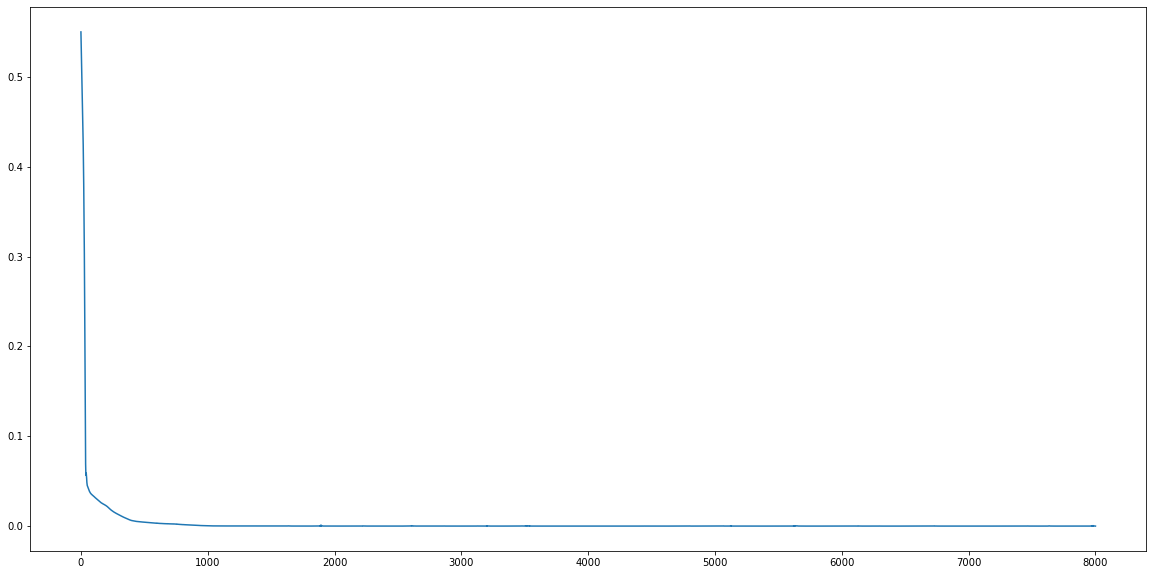

In [ ]:
fig = plt.figure(figsize = (20,10))
plt.plot(train_loss_avg) 
plt.show()

In [ ]:
def traverseleaf(root):
    if root is not None:
        traverseleaf(root.left)
        if root.is_leaf():
            print(root.radius)
        traverseleaf(root.right)
        return 

In [ ]:
def traversebif(root):
    if root is not None:
        traversebif(root.left)
        if root.is_two_child():
            print(root.radius)
        traversebif(root.right)
        return 

In [ ]:
traversebif(decoded)
print("////")
traversebif(input)

tensor([[0.3076, 0.0895, 0.1057, 0.3334]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[ 2.1714e-04,  1.0490e-05, -2.0231e-05, -4.4443e-05]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0.7619, 0.7292, 0.7403, 0.6714]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0.3850, 0.3609, 0.3718, 0.3348]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
////
tensor([0.3077, 0.0909, 0.1053, 0.3333], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0.7692, 0.7273, 0.7368, 0.6667], device='cuda:0')
tensor([0.3846, 0.3636, 0.3684, 0.3333], device='cuda:0')


In [ ]:
traverseleaf(decoded)

tensor([[0.6155, 0.1789, 0.2109, 0.6657]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0.6909, 0.4516, 0.4784, 0.6652]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0.9243, 0.2678, 0.3202, 1.0016]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0.9976, 0.5389, 0.5869, 1.0000]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0.8381, 0.9955, 1.0046, 0.6704]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [ ]:
traverseleaf(input)

tensor([0.6154, 0.1818, 0.2105, 0.6667], device='cuda:0')
tensor([0.6923, 0.4545, 0.4737, 0.6667], device='cuda:0')
tensor([0.9231, 0.2727, 0.3158, 1.0000], device='cuda:0')
tensor([1.0000, 0.5455, 0.5789, 1.0000], device='cuda:0')
tensor([0.8462, 1.0000, 1.0000, 0.6667], device='cuda:0')
